In [56]:
# Standard python helper libraries.

import json, os, re, shutil, sys, time
import itertools, collections
from importlib import reload
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# NumPy and SciPy for matrix ops
import numpy as np
import scipy.sparse
import pandas as pd
import tensorflow as tf
assert(tf.__version__.startswith("1."))
from sklearn.cross_validation import train_test_split

# NLTK for NLP utils
import nltk
import gzip
from collections import namedtuple
import tflearn
# Helper libraries
from w266_common import vocabulary, tf_embed_viz, glove_helper
from w266_common import utils; reload(utils)


<module 'w266_common.utils' from '/home/ubuntu/project/w266_common/utils.py'>

In [65]:
#Using pretrained GLove embeddings
hands = glove_helper.Hands(ndim=100)  # 50, 100, 200, 300 dim are available

Loading vectors from data/glove/glove.6B.zip
Parsing file: data/glove/glove.6B.zip:glove.6B.100d.txt
Found 400,000 words.
Parsing vectors... Done! (W.shape = (400003, 100))


In [66]:
hands.shape

(400003, 100)

In [3]:
#Function to read the amazon review data files
def parse(path):
  print('start parse')
  start_parse = time.time()
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)
  end_parse = time.time()
  print('end parse with time for parse',end_parse - start_parse)

def getDF(path):
  print('start getDF')
  start = time.time()
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  print('end getDF')
  end = time.time()
  print('time taken to load data = ',end-start)
  return pd.DataFrame.from_dict(df, orient='index')
#df = getDF('reviews_Toys_and_Games.json.gz') #old def function corresponding to the step bt step vectorization

In [4]:
df_hnk = getDF('reviews_Home_and_Kitchen.json.gz')

start getDF
start parse
end parse with time for parse 238.9102017879486
end getDF
time taken to load data =  238.9109025001526


In [ ]:
df_vid = getDF('reviews_Video_Games.json.gz')

In [ ]:
df_aut = getDF('reviews_Automotive.json.gz')

In [ ]:
df_toys = getDF('reviews_Toys_and_Games.json.gz')

In [13]:
#Create train,dev,test split
from sklearn.model_selection import train_test_split
# train_toys,devtest = train_test_split(df_toys, test_size=0.4, random_state=42)
# dev_toys,test_toys = train_test_split(devtest,test_size = 0.5, random_state=42)
# print('Toy reviews train, dev and test set dataframe shape:',train_toys.shape,dev_toys.shape,test_toys.shape)

#For Video games reviews
# train_vid,devtest = train_test_split(df_vid, test_size=0.4)
# dev_vid,test_vid = train_test_split(devtest,test_size = 0.5)
# print('Video games reviews train, dev and test set dataframe shape:',train_vid.shape,dev_vid.shape,test_vid.shape)

#For Auto reviews
# train_aut,devtest = train_test_split(df_aut, test_size=0.4)
# dev_aut,test_aut = train_test_split(devtest,test_size = 0.5)
# print('Auto reviews train, dev and test set dataframe shape:',train_aut.shape,dev_aut.shape,test_aut.shape)

#For Home and Kitchen reviews
train_hnk,devtest = train_test_split(df_hnk, test_size=0.4, random_state=42)
dev_hnk,test_hnk = train_test_split(devtest,test_size = 0.5, random_state=42)
print('Home and Kitchen reviews train, dev and test set dataframe shape:',train_hnk.shape,dev_hnk.shape,test_hnk.shape)

Home and Kitchen reviews train, dev and test set dataframe shape: (2552355, 9) (850785, 9) (850786, 9)


In [14]:
#checking that we have different productids
print(train_hnk.head(5))

         overall                                         reviewText  \
2315529      3.0  It's great as a panini grill, but it takes for...   
3381949      4.0  I originally intended to buy another brand mad...   
2015374      5.0  This item was well made, and the instructions ...   
2378385      5.0  I was hoping that this would wrap around the m...   
3962814      5.0  These barstools are amazing. After scouring st...   

                                      summary        asin   reviewTime  \
2315529  Not as good as I thought it would be  B002YD99Y4   03 2, 2013   
3381949               Good for the price paid  B006G57132  10 12, 2013   
2015374                           Cork Trivet  B00283ZQL0  01 10, 2014   
2378385                        Very satisfied  B0035E63WM  06 20, 2014   
3962814  Amazing quality for an amazing price  B00BLSEIB2  04 30, 2014   

        helpful      reviewerID      reviewerName  unixReviewTime  
2315529  [0, 0]  A1KPJ12YFSE293            CathyB      13621

In [15]:
#Function to create a smaller sized train and dev data set. Enables testing accuracy for different sizes.
#Also binarizes the labels. Ratings of 1,2 and to 0; Ratings of 4,5 to 1.

def set_df_size(size,data_train,data_dev):
    size_train = size
    len_max_train = data_train[data_train.overall!=3].shape[0] #max possible length of train data set taking out the 3 ratings.
    #print("Number of reviews with ratings != 3 in train set",len_max_train)
    temp_size_train = min(len_max_train,size_train)

    len_max_dev = data_dev[data_dev.overall!=3].shape[0]
    #print("Number of reviews with ratings != 3 in dev set",len_max_dev)
    temp_size_dev = min(len_max_dev,int(0.3*temp_size_train)) #making the dev set about 0.3 times the train set.

    temp_train_data = data_train[data_train.overall != 3][:temp_size_train]
    #print('Size of train data',temp_train_data.shape)
    #print(temp_train_data.groupby('overall').count())
    #print(temp_train_toys[:5])

    temp_dev_data = data_dev[data_dev.overall!=3][:temp_size_dev]
    #print('Size of dev data',temp_dev_data.shape)
    #print(temp_dev_data.groupby('overall').count())
    #print(temp_dev_data[:2])
    
    #Binarize ratings
    temp_train_y = np.zeros(temp_size_train)
    temp_train_y[temp_train_data.overall > 3] = 1
    temp_dev_y = np.zeros(temp_size_dev)
    temp_dev_y[temp_dev_data.overall>3] = 1
    #print('binarized y shape',temp_train_y.shape,temp_dev_y.shape)
    #print(temp_dev_y[:20],data_dev.overall[:20])
    return temp_train_data,temp_dev_data,temp_train_y,temp_dev_y

In [16]:
print(print(dev_hnk.head(5)))

         overall                                         reviewText  \
1984789      1.0  My poster was horribly damaged when it was shi...   
4251355      5.0  Excellent Product! Quality shipping and packag...   
523170       5.0  This product is fantastic ! Before I purchased...   
2489673      2.0  lid doesnt secure well. just buy one at a loca...   
953589       2.0  My kids were very excited to make Popsicles us...   

                                          summary        asin   reviewTime  \
1984789                          Damaged shipping  B0025NY19Q   07 8, 2013   
4251355  Awesome product, and very fast shipping.  B00KK5ITO4   06 1, 2014   
523170                               meat grinder  B0002I5QHW   07 8, 2013   
2489673                                     cheap  B003FZBI7G  12 18, 2013   
953589                      Broke after first use  B000G34F1Q  06 28, 2013   

        helpful      reviewerID   reviewerName  unixReviewTime  
1984789  [0, 1]  A1693NIWIIZ7H0        

In [17]:
list_df = ['toys','vid','aut','hnk'] #list of keys that refer to each dataframe. Adding a new dataframe would require updating this list
dict_train_df = {} #Dict to store train input data frame for each domain, can be accessed by using domain name as key
dict_dev_df = {} #Dict to store dev input data frame for each domain, can be accessed by using domain name as key
dict_train_y = {} #Dict to store binarized train data label for each domain
dict_dev_y = {} #Dict to store binarized dev data label for each domain
#print(len(dict_train_df))

def create_sized_data(size = 10000):
    size_train = size #Set size of train set here. This is a hyperparameter.
#     key = list_df[0]
    #print('Toys reviews\n')
#     dict_train_df[key], dict_dev_df[key], dict_train_y[key], dict_dev_y[key] = set_df_size(size_train,train_toys,dev_toys)
#     #print('\n Video games reviews\n')
#     key = list_df[1]
#     dict_train_df[key], dict_dev_df[key], dict_train_y[key], dict_dev_y[key] = set_df_size(size_train,train_vid,dev_vid)
#     #print('\n Auto reviews\n')
#     key = list_df[2]
#     dict_train_df[key], dict_dev_df[key], dict_train_y[key], dict_dev_y[key] = set_df_size(size_train,train_aut,dev_aut)
    #print('\n Home and Kitchen reviews\n')
    key = list_df[3]
    dict_train_df[key], dict_dev_df[key], dict_train_y[key], dict_dev_y[key] = set_df_size(size_train,train_hnk,dev_hnk)
    
create_sized_data()
#print(len(dict_train_df))

In [20]:
list_df = ['toys','vid','aut','hnk'] #list of keys that refer to each dataframe. Adding a new dataframe would require updating this list
dict_train_df = {} #Dict to store train input data frame for each domain, can be accessed by using domain name as key
dict_dev_df = {} #Dict to store dev input data frame for each domain, can be accessed by using domain name as key
dict_train_y = {} #Dict to store binarized train data label for each domain
dict_dev_y = {} #Dict to store binarized dev data label for each domain
#print(len(dict_train_df))

def create_sized_data(size = 100000):
    size_train = size #Set size of train set here. This is a hyperparameter.
    key = list_df[3]
    #print('Toys reviews\n')

#     dict_train_df[key], dict_dev_df[key], dict_train_y[key], dict_dev_y[key] = set_df_size(size_train,train_toys,dev_toys)
#     #print('\n Video games reviews\n')
#     key = list_df[1]
#     dict_train_df[key], dict_dev_df[key], dict_train_y[key], dict_dev_y[key] = set_df_size(size_train,train_vid,dev_vid)
#     #print('\n Auto reviews\n')
#     key = list_df[2]
#     dict_train_df[key], dict_dev_df[key], dict_train_y[key], dict_dev_y[key] = set_df_size(size_train,train_aut,dev_aut)
#     #print('\n Home and Kitchen reviews\n')
    key = list_df[3]
    dict_train_df[key], dict_dev_df[key], dict_train_y[key], dict_dev_y[key] = set_df_size(size_train,train_hnk,dev_hnk)
    
create_sized_data()
#print(len(dict_train_df))

In [18]:
import nltk
nltk.download('punkt')
from nltk import word_tokenize


[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [21]:
print(dict_train_df['hnk'].shape[0])

100000


In [35]:
#Preprocessing steps

#Changing to nltk punkt tokenizer as the periods are not getting removed
print(dict_train_df['hnk'].shape[0])

train_cnt = collections.Counter()
x_train_tokens_list = []
start = time.time()
for i in range(dict_train_df['hnk'].shape[0]):
    #print(dict_train_df['hnk'].iloc[i][2])
    x_train_tokens = word_tokenize(dict_train_df['hnk'].iloc[i][1])
    
    

    #2. changing to lowercase and replacing numbers(are we losing any context by 
    #replacing all numbers in the review test? Are we losing any context here)
    x_tokens_canonical = utils.canonicalize_words(x_train_tokens)
    
    x_train_tokens_list.append(x_tokens_canonical)
    
    if i%10000 == 0:
        print(i) 
    #3. Build vocabulary
    for items in x_tokens_canonical:
            train_cnt[items] += 1
            
vocab = vocabulary.Vocabulary(train_cnt, size=None)  # size=None means unlimited
total_words = sum(train_cnt.values())
print("x_train_tokens_list length", len(x_train_tokens_list))
print("Vocabulary size: {:,}".format(vocab.size))
#print("Vocabulary dict: ", vocab.word_to_id)
print("Total words ",total_words )


100000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
x_train_tokens_list length 100000
Vocabulary size: 103,554
Total words  7875508


In [46]:
print(len(x_train_tokens_list[1]))

40


In [50]:
print(len(x_train_tokens_list[0]))

125


In [49]:
print(x_train_tokens_list[1])

['this', 'item', 'was', 'well', 'made', ',', 'and', 'the', 'instructions', 'for', 'personalizing', 'it', 'by', 'the', 'persons', 'for', 'whom', 'i', 'bought', 'it', 'were', 'clear', 'and', 'uncomplicated', '.', 'so', 'i', 'hope', 'they', 'will', 'enjoy', 'putting', 'it', 'together', 'with', 'their', 'many', 'wine', 'corks', '.']


In [51]:
print(x_train_tokens_list[0])

['i', 'originally', 'intended', 'to', 'buy', 'another', 'brand', 'made', 'in', 'italy', 'which', 'has', 'very', 'similar', 'design', 'also', 'has', 'the', 'mirror', 'front', 'which', 'would', 'cost', 'at', 'least', 'double', 'but', 'would', 'arrive', 'assembled', '.', 'i', 'ended', 'up', 'getting', 'this', 'model', 'instead', 'based', 'on', 'the', 'cost', '.', 'the', 'assembly', 'process', 'was', 'tedious', 'and', 'time-consuming', ',', 'but', 'the', 'parts', 'are', 'connected', 'well', 'and', 'quality', 'are', 'ok', '.', 'the', 'package', 'was', 'delivered', 'by', 'ups', 'and', 'one', 'of', 'the', 'mirror', 'board', 'arrived', 'with', 'cracks', '.', 'i', 'emailed', 'the', 'customer', 'service', 'according', 'to', 'the', 'information', 'on', 'an', 'insert', 'and', 'received', 'a', 'quick', 'reply', 'letting', 'me', 'know', 'that', 'the', 'replacement', 'part', 'will', 'be', 'shipped', 'to', 'me', 'in', 'about', 'a', 'week', '.', 'each', 'compartment', 'have', 'no', 'problem', 'accommod

In [11]:
#Converting all reviews to ids 
train_id_list = []
for item in x_train_tokens_list:
    train_id_list.append(vocab.words_to_ids(item))
    
test_id_list = []
for item in x_test_tokens_list:
    test_id_list.append(vocab.words_to_ids(item))    

In [47]:
print((x_train_tokens_list[1]))

['this', 'item', 'was', 'well', 'made', ',', 'and', 'the', 'instructions', 'for', 'personalizing', 'it', 'by', 'the', 'persons', 'for', 'whom', 'i', 'bought', 'it', 'were', 'clear', 'and', 'uncomplicated', '.', 'so', 'i', 'hope', 'they', 'will', 'enjoy', 'putting', 'it', 'together', 'with', 'their', 'many', 'wine', 'corks', '.']


In [58]:
print(max((train_id_list)))

[4301, 76, 4302, 305, 4149, 570, 166, 76, 54, 41, 138, 4, 145, 223, 80, 19, 235, 95, 44, 704, 168, 76, 41, 4303, 26, 147, 6, 12, 4304, 3428, 970, 10, 915, 706, 1326, 706, 50, 17, 412, 706, 983, 343, 19, 235, 12, 43, 1457, 76, 12, 34, 23, 489, 2088, 43, 245, 36, 979, 13, 1612, 2496, 498, 289, 12, 232, 87, 2659, 10]


In [39]:
review_lengths = [len(review) for review in x_train_tokens_list]
print("Shortest review:", min(review_lengths))
print("Longest review:",max(review_lengths))


Shortest review: 0
Longest review: 5990


[]

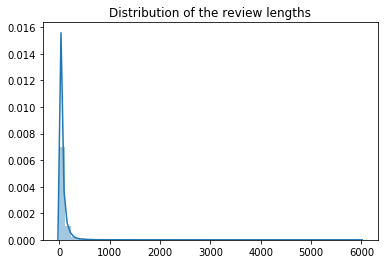

In [40]:
ax = plt.axes()
sns.distplot(review_lengths)
ax.set_title("Distribution of the review lengths")
plt.plot()

In [41]:
pd.DataFrame(review_lengths).describe()

,0
count,100000.000000
mean,78.755080
std,94.835379
min,0.000000
25%,30.000000
50%,49.000000
75%,91.000000
max,5990.000000


In [52]:
pd.DataFrame(review_lengths).quantile(0.9)

0    162.0
Name: 0.9, dtype: float64

#Based on the above, we are setting a max_length of 150

In [57]:
max_length =150
vocab_processor = tflearn.data_utils.VocabularyProcessor(max_length, min_frequency=0)
#Note : This function seems to be deprecated. Another function I ran into 
# tflearn.data_utils.VocabularyProcessor (max_document_length, min_frequency=3, vocabulary=None, tokenizer_fn=None)

def process_inputs(key, vocab_processor):
    
    # For simplicity, we call our features x and our outputs y
    start_vectorize = time.time()
    x_train = dict_train_df[key].reviewText
    y_train = dict_train_y[key]
    x_dev = dict_dev_df[key].reviewText
    y_dev = dict_dev_y[key]
    print(x_train.shape)
    
    # Train the vocab_processor from the training set
    x_train = vocab_processor.fit_transform(x_train)
    # Transform our test set with the vocabulary processor
    x_dev = vocab_processor.transform(x_dev)

    # We need these to be np.arrays instead of generators
    x_train = np.array(list(x_train))
    print(x_train.shape)
    x_dev = np.array(list(x_dev))
    y_train = np.array(y_train).astype(int)
    y_dev = np.array(y_dev).astype(int)
    
#     y_train = tf.expand_dims(y_train,1)
#     y_dev = tf.expand_dims(y_dev,1)
    print('y train shape',y_train.shape)

    V = len(vocab_processor.vocabulary_)
    print('Total words: %d' % V)
    end_vectorize = time.time()
    print('Time taken to vectorize %d size dataframe'%x_train.shape[0],end_vectorize-start_vectorize)

    # Return the transformed data and the number of words
    return x_train, y_train, x_dev, y_dev, V

x_train, y_train, x_dev, y_dev, V = process_inputs('hnk',vocab_processor)

#Print a few examples for viewing
print('sample review',dict_train_df['hnk']['reviewText'].iloc[3],'\n')
print('corresponding ids\n',x_train[3])
print('sample review',dict_dev_df['hnk']['reviewText'].iloc[3],'\n')
print('corresponding ids\n',x_dev[3])

(100000,)
(100000, 150)
y train shape (100000,)
Total words: 90595
Time taken to vectorize 100000 size dataframe 16.173495054244995
sample review These barstools are amazing. After scouring stores and the internet, I decided that these would be my best bet. I needed sturdy stools to deal with heavy use from kids, family, ect. They are 1000% solid. When they arrive you have to screw the seat onto the base swivel mechanism, however all the important parts that make it solid are already in place. You also have to attach the solid wooden seat onto the frame. The seat isn't pre-drilled so that is a bit annoying. Not hard, but annoying. These stools are going to last a very long time, without a doubt. I wouldn't hesitate to buy more. They feel stronger, more solid, and of higher quality than stools I saw for $300 each. I was a little nervous they would look clunky, but they are beautiful with very nice lines. I wish I would have ordered them two months ago when I first saw them.I forgot to m

In [58]:
train_ids = x_train
dev_ids = x_dev

In [59]:
print(train_ids.shape)

(100000, 150)


In [14]:
print(train_ids[0])

[ 3  4  5  6  7  8  9 10 11 12 13 14 15 12 10 16 17 18 19 20  7 21 22 10 23
 24 25 26 27 28  6 29 10 30 31 12 32 33 13 12 34 35 36 36 37 38 19 39 32 26
  9 40 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]


In [60]:
print(y_train.shape)
print(train_ids.shape)
print(dev_ids.shape)

(100000,)
(100000, 150)
(30000, 150)


In [76]:
lstm_size = 256
lstm_layers = 1
#batch_size = 50
batch_size = 128
learning_rate = 0.001
embed_size = 100

In [62]:
def batch_iterator(ids, labels, batch_size=100):
    
    n_batches = len(ids)//batch_size
    ids, labels = ids[:n_batches*batch_size], labels[:n_batches*batch_size]
    
    for ii in range(0, len(ids), batch_size):
        yield ids[ii:ii+batch_size], labels[ii:ii+batch_size]
        

In [67]:
def build_rnn(gl_embed=hands.W,
              embed_size=embed_size,
              batch_size=batch_size,
              learning_rate=learning_rate,
              lstm_size=lstm_size,
              lstm_layers=lstm_layers):
    
    tf.reset_default_graph()
    
    #n_words = len(vocabulary_to_int)
    
    with tf.name_scope('inputs'):
        inputs_ = tf.placeholder(tf.int32,[None, None],name='inputs_')
    with tf.name_scope('labels'):
        labels_ = tf.placeholder(tf.int32,[None, None],name='labels_')
    with tf.name_scope('keep_prob'):    
        keep_prob = tf.placeholder(tf.float32,name='keep_prob')
        
    with tf.name_scope('embedding'):
#         embedding = tf.Variable(tf.random_normal((n_words,embed_size),-1,1),name='embedding_')
#         embed = tf.nn.embedding_lookup(embedding,inputs_)
        embedding=tf.get_variable(name="embedding_",shape=gl_embed.shape,
                                       initializer=tf.constant_initializer(gl_embed),trainable=False)
        embed = tf.nn.embedding_lookup(embedding, inputs_)
        
    with tf.name_scope("RNN_cells"):
        lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)

        # Add dropout to the cell
        drop = tf.contrib.rnn.DropoutWrapper(lstm,output_keep_prob=keep_prob)

        # Stack up multiple LSTM layers, for deep learning
        cell = tf.contrib.rnn.MultiRNNCell([drop]*lstm_layers)
        
        with tf.name_scope("RNN_init_state"):
            # Getting an initial state of all zeros
            initial_state = cell.zero_state(batch_size, tf.float32)
    
    with tf.name_scope("RNN_forward"):
        outputs, final_state = tf.nn.dynamic_rnn(cell, embed, initial_state=initial_state)
        
    with tf.name_scope('predictions'):
        predictions = tf.contrib.layers.fully_connected(outputs[:, -1], 1, 
                                                        activation_fn=tf.sigmoid,
                                                        weights_initializer=
                                                        tf.truncated_normal_initializer(stddev=0.1))   
    with tf.name_scope('cost'):
        cost = tf.losses.mean_squared_error(labels_, predictions)
        tf.summary.scalar('cost', cost)
    
    with tf.name_scope('train'):
        optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    
    with tf.name_scope('accuracy'):
        correct_pred = tf.equal(tf.cast(tf.round(predictions), tf.int32), labels_)
        accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    
    merged = tf.summary.merge_all()
    
    # Export the nodes 
    export_nodes = ['inputs_', 'labels_','initial_state', 'final_state',
                    'keep_prob', 'cell', 'cost', 'predictions', 'optimizer',
                    'accuracy','merged']
    
    Graph = namedtuple('Graph', export_nodes)
    
    local_dict = locals()
    graph = Graph(*[local_dict[each] for each in export_nodes])
    
    return graph

In [77]:
graph = build_rnn(gl_embed=hands.W,
              embed_size=embed_size,
              batch_size=batch_size,
              learning_rate=learning_rate,
              lstm_size=lstm_size,
              lstm_layers=lstm_layers)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    file_writer = tf.summary.FileWriter('output/logs/1', sess.graph)

In [80]:


def train(model, epoch,train_writer,test_writer):
    
    saver = tf.train.Saver()

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
    
        iteration = 1
        for e in range(epochs):
            state = sess.run(model.initial_state)

            for ii, (x, y) in enumerate(batch_iterator(train_ids, y_train, batch_size), 1):
                
                feed = {model.inputs_: x,
                        model.labels_: y[:, None],
                        model.keep_prob: 0.5,
                        model.initial_state: state}
                summary,loss, state, _ = sess.run([model.merged,model.cost, 
                                                   model.final_state, 
                                                   model.optimizer], feed_dict=feed)

                
                

                if iteration%100==0:
                    print("Epoch: {}/{}".format(e, epochs),
                          "Iteration: {}".format(iteration),
                          "Train loss: {:.3f}".format(loss))
                    train_writer.add_summary(summary, iteration)
                    val_acc = []
                    val_state = sess.run(model.cell.zero_state(batch_size, tf.float32))
                    
                    for x, y in batch_iterator(dev_ids, y_dev, batch_size):
                        feed = {model.inputs_: x,
                                model.labels_: y[:, None],
                                model.keep_prob: 1,
                                model.initial_state: val_state}
                        summary, dev_loss,batch_acc, val_state = sess.run([model.merged, model.cost,model.accuracy, 
                                                         model.final_state], feed_dict=feed)
                        #print('batch_acc', batch_acc)
                        val_acc.append(batch_acc)

                    test_writer.add_summary(summary,iteration)
                    print("Dev loss: {:.3f}".format(dev_loss))
                    print("Dev acc: {:.3f}".format(np.mean(val_acc)))

                iteration +=1
        saver.save(sess, "output/checkpoints/sentiment.ckpt")

In [60]:
print(test_ids)

[[  41  195    4 ...,    0    0    0]
 [  41 2656    6 ...,    0    0    0]
 [  41  101   44 ...,    0    0    0]
 ..., 
 [   7  970   15 ...,    0    0    0]
 [  41   52    4 ...,    0    0    0]
 [ 142 1744  288 ...,    0    0    0]]


In [70]:
lstm_size_options = [256]
lstm_layers_options = [1]
learning_rate_options = [0.001]

In [81]:
epochs=200
for lstm_size in lstm_size_options:
    for lstm_layers in lstm_layers_options:
        for learning_rate in learning_rate_options:
            log_string_train = 'output/logs/2/train/lr={},rl={},ru={}'.format(learning_rate, lstm_layers, lstm_size)
            log_string_test = 'output/logs/2/test/lr={},rl={},ru={}'.format(learning_rate, lstm_layers, lstm_size)
            train_writer = tf.summary.FileWriter(log_string_train)
            test_writer = tf.summary.FileWriter(log_string_test)
            
            print("lstm size: {}".format(lstm_size),
                    "nb layers : {}".format(lstm_layers),
                    "learn rate : {:.3f}".format(learning_rate))
            
            model = build_rnn(gl_embed=hands.W,
                      embed_size=embed_size,
                      batch_size=batch_size,
                      learning_rate=learning_rate,
                      lstm_size=lstm_size,
                      lstm_layers=lstm_layers)

            train(model, epochs, train_writer,test_writer)

lstm size: 256 nb layers : 1 learn rate : 0.001
Epoch: 0/200 Iteration: 100 Train loss: 0.140
Dev loss: 0.173
Dev acc: 0.830
Epoch: 0/200 Iteration: 200 Train loss: 0.176
Dev loss: 0.170
Dev acc: 0.830
Epoch: 0/200 Iteration: 300 Train loss: 0.114
Dev loss: 0.172
Dev acc: 0.830
Epoch: 0/200 Iteration: 400 Train loss: 0.140
Dev loss: 0.168
Dev acc: 0.830
Epoch: 0/200 Iteration: 500 Train loss: 0.107
Dev loss: 0.169
Dev acc: 0.830
Epoch: 0/200 Iteration: 600 Train loss: 0.111
Dev loss: 0.169
Dev acc: 0.830
Epoch: 0/200 Iteration: 700 Train loss: 0.138
Dev loss: 0.169
Dev acc: 0.830
Epoch: 1/200 Iteration: 800 Train loss: 0.165
Dev loss: 0.168
Dev acc: 0.830
Epoch: 1/200 Iteration: 900 Train loss: 0.131
Dev loss: 0.166
Dev acc: 0.830
Epoch: 1/200 Iteration: 1000 Train loss: 0.128
Dev loss: 0.172
Dev acc: 0.830
Epoch: 1/200 Iteration: 1100 Train loss: 0.108
Dev loss: 0.168
Dev acc: 0.830
Epoch: 1/200 Iteration: 1200 Train loss: 0.132
Dev loss: 0.170
Dev acc: 0.830
Epoch: 1/200 Iteration: 1

Dev loss: 0.077
Dev acc: 0.909
Epoch: 13/200 Iteration: 10600 Train loss: 0.013
Dev loss: 0.082
Dev acc: 0.910
Epoch: 13/200 Iteration: 10700 Train loss: 0.038
Dev loss: 0.072
Dev acc: 0.903
Epoch: 13/200 Iteration: 10800 Train loss: 0.035
Dev loss: 0.086
Dev acc: 0.912
Epoch: 13/200 Iteration: 10900 Train loss: 0.037
Dev loss: 0.078
Dev acc: 0.909
Epoch: 14/200 Iteration: 11000 Train loss: 0.020
Dev loss: 0.099
Dev acc: 0.883
Epoch: 14/200 Iteration: 11100 Train loss: 0.040
Dev loss: 0.070
Dev acc: 0.906
Epoch: 14/200 Iteration: 11200 Train loss: 0.024
Dev loss: 0.067
Dev acc: 0.915
Epoch: 14/200 Iteration: 11300 Train loss: 0.029
Dev loss: 0.062
Dev acc: 0.914
Epoch: 14/200 Iteration: 11400 Train loss: 0.025
Dev loss: 0.071
Dev acc: 0.913
Epoch: 14/200 Iteration: 11500 Train loss: 0.048
Dev loss: 0.086
Dev acc: 0.910
Epoch: 14/200 Iteration: 11600 Train loss: 0.033
Dev loss: 0.069
Dev acc: 0.911
Epoch: 14/200 Iteration: 11700 Train loss: 0.033
Dev loss: 0.084
Dev acc: 0.909
Epoch: 15

Dev loss: 0.071
Dev acc: 0.914
Epoch: 26/200 Iteration: 20900 Train loss: 0.016
Dev loss: 0.072
Dev acc: 0.915
Epoch: 26/200 Iteration: 21000 Train loss: 0.010
Dev loss: 0.091
Dev acc: 0.914
Epoch: 27/200 Iteration: 21100 Train loss: 0.024
Dev loss: 0.097
Dev acc: 0.902
Epoch: 27/200 Iteration: 21200 Train loss: 0.014
Dev loss: 0.080
Dev acc: 0.913
Epoch: 27/200 Iteration: 21300 Train loss: 0.027
Dev loss: 0.097
Dev acc: 0.901
Epoch: 27/200 Iteration: 21400 Train loss: 0.008
Dev loss: 0.090
Dev acc: 0.913
Epoch: 27/200 Iteration: 21500 Train loss: 0.037
Dev loss: 0.086
Dev acc: 0.914
Epoch: 27/200 Iteration: 21600 Train loss: 0.039
Dev loss: 0.082
Dev acc: 0.910
Epoch: 27/200 Iteration: 21700 Train loss: 0.017
Dev loss: 0.089
Dev acc: 0.911
Epoch: 27/200 Iteration: 21800 Train loss: 0.016
Dev loss: 0.099
Dev acc: 0.914
Epoch: 28/200 Iteration: 21900 Train loss: 0.019
Dev loss: 0.098
Dev acc: 0.912
Epoch: 28/200 Iteration: 22000 Train loss: 0.035
Dev loss: 0.075
Dev acc: 0.912
Epoch: 28

Dev loss: 0.127
Dev acc: 0.905
Epoch: 39/200 Iteration: 31200 Train loss: 0.029
Dev loss: 0.096
Dev acc: 0.914
Epoch: 40/200 Iteration: 31300 Train loss: 0.013
Dev loss: 0.105
Dev acc: 0.915
Epoch: 40/200 Iteration: 31400 Train loss: 0.020
Dev loss: 0.084
Dev acc: 0.917
Epoch: 40/200 Iteration: 31500 Train loss: 0.009
Dev loss: 0.093
Dev acc: 0.912
Epoch: 40/200 Iteration: 31600 Train loss: 0.025
Dev loss: 0.102
Dev acc: 0.915
Epoch: 40/200 Iteration: 31700 Train loss: 0.001
Dev loss: 0.102
Dev acc: 0.916
Epoch: 40/200 Iteration: 31800 Train loss: 0.001
Dev loss: 0.093
Dev acc: 0.915
Epoch: 40/200 Iteration: 31900 Train loss: 0.008
Dev loss: 0.096
Dev acc: 0.915
Epoch: 40/200 Iteration: 32000 Train loss: 0.013
Dev loss: 0.095
Dev acc: 0.914
Epoch: 41/200 Iteration: 32100 Train loss: 0.023
Dev loss: 0.087
Dev acc: 0.915
Epoch: 41/200 Iteration: 32200 Train loss: 0.008
Dev loss: 0.080
Dev acc: 0.915
Epoch: 41/200 Iteration: 32300 Train loss: 0.007
Dev loss: 0.080
Dev acc: 0.916
Epoch: 41

KeyboardInterrupt: 

In [82]:
print("run")

run
